# Thermovision segmentation (altitude & rotation)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.utils.read_file import XMLReader, read_file_to_list
from src.utils.process_image import add_altitude_rotation_channel
from src.visualizations import plot_oriented_annotations, plot_rotated_images

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

#### Load annotations

In [2]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

In [3]:
# examplary annotation
annotations['0_100_30_0_03280']

{'picname': '0_100_30_0_03280.jpg',
 'size': {'width': 640, 'height': 512, 'depth': 1},
 'nobbox': [],
 'robbox': [{'category': 'Car',
   'cx': 215.984,
   'cy': 120.9863,
   'w': 32.276,
   'h': 15.9103,
   'angle': 2.589049,
   'difficult': False},
  {'category': 'Car',
   'cx': 373.7907,
   'cy': 97.5358,
   'w': 27.4285,
   'h': 19.3339,
   'angle': 0.559865,
   'difficult': False},
  {'category': 'Car',
   'cx': 134.6054,
   'cy': 141.7191,
   'w': 25.4252,
   'h': 18.4471,
   'angle': 2.279669,
   'difficult': False},
  {'category': 'Car',
   'cx': 32.4545,
   'cy': 200.0871,
   'w': 27.7836,
   'h': 13.3051,
   'angle': 0.796474,
   'difficult': False},
  {'category': 'Car',
   'cx': 43.7676,
   'cy': 192.7359,
   'w': 31.907,
   'h': 17.0008,
   'angle': 0.650521,
   'difficult': False},
  {'category': 'Car',
   'cx': 58.5022,
   'cy': 187.6378,
   'w': 14.5995,
   'h': 32.0022,
   'angle': 2.335935,
   'difficult': False},
  {'category': 'Car',
   'cx': 67.869,
   'cy': 181.10

In [4]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set

In [5]:
n = 15
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

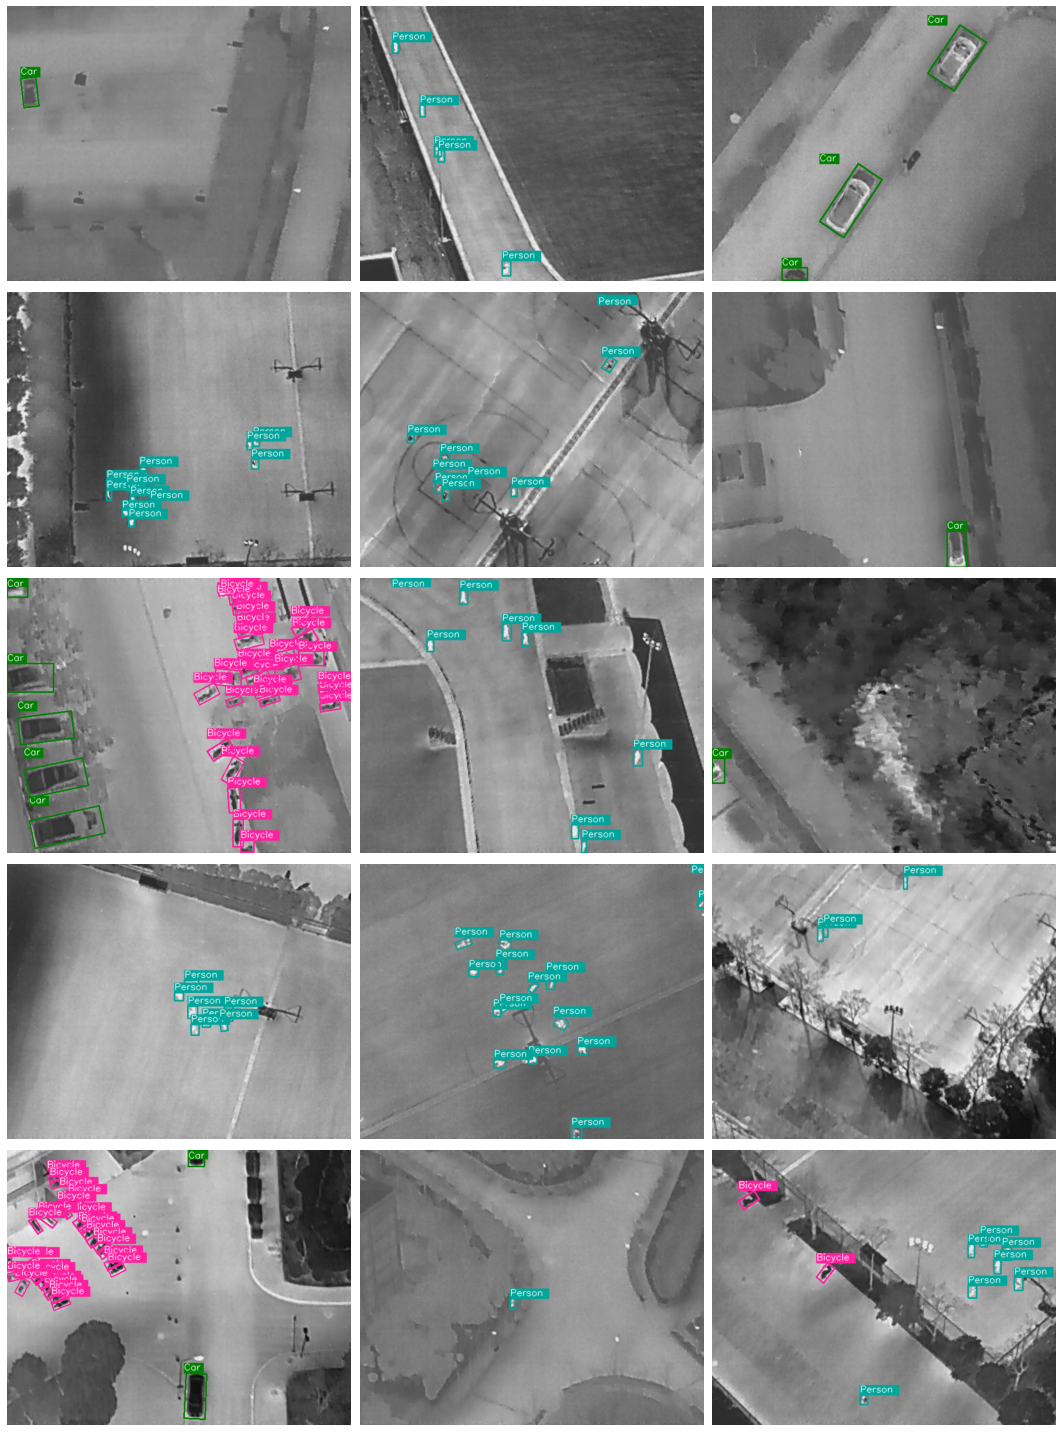

In [6]:
rows = 5
cols = 3
plot_rotated_images(IMAGES_PATH, random_images, annotations, rows, cols)

### Add the altitude information as an additional input channel

Following the idea from the paper: [Elevating point-based object detection in UAVs: A deep learning method with altitude fusion](https://ww2.mini.pw.edu.pl/pprai2024/papers/105.pdf) <br>(presented at the PP RAI 2024 conference), we added the information about the altitude as a separate channel (i.e. using *Method A*):

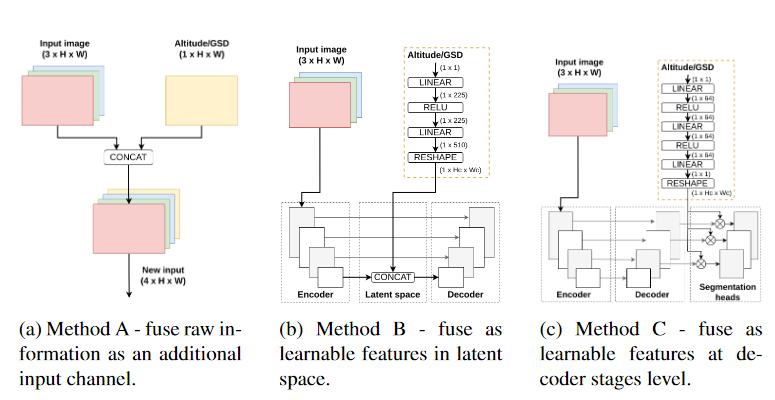

In [7]:
image_name = image_names['train'][0]

image = cv2.imread(f"{IMAGES_PATH}/{image_name}.jpg")

In [8]:
print(image_name)
image_alt_rot = add_altitude_rotation_channel(image, image_name)
print(image_alt_rot.shape)
image_alt_rot

1_130_90_0_04077
(512, 640, 3)


array([[[120, 130,  90],
        [118, 130,  90],
        [118, 130,  90],
        ...,
        [145, 130,  90],
        [145, 130,  90],
        [146, 130,  90]],

       [[119, 130,  90],
        [117, 130,  90],
        [117, 130,  90],
        ...,
        [146, 130,  90],
        [148, 130,  90],
        [148, 130,  90]],

       [[118, 130,  90],
        [119, 130,  90],
        [120, 130,  90],
        ...,
        [147, 130,  90],
        [149, 130,  90],
        [149, 130,  90]],

       ...,

       [[118, 130,  90],
        [119, 130,  90],
        [123, 130,  90],
        ...,
        [137, 130,  90],
        [140, 130,  90],
        [141, 130,  90]],

       [[123, 130,  90],
        [122, 130,  90],
        [122, 130,  90],
        ...,
        [139, 130,  90],
        [143, 130,  90],
        [145, 130,  90]],

       [[126, 130,  90],
        [122, 130,  90],
        [120, 130,  90],
        ...,
        [142, 130,  90],
        [147, 130,  90],
        [150, 130,  90]]

Next steps:
- create a training pipeline (starting with e.g. U-net)
- define a loss function for rotated images